# Investigating the step change in behaviour with lead time apparent in the forecasts in 2005

In [1]:
import glob

import dask

import xesmf

import cftime

import numpy as np
import xarray as xr

import matplotlib.pyplot as plt

In [2]:
# from xmovie import Movie

import cartopy
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader

from matplotlib import gridspec

In [3]:
cartopy.config["pre_existing_data_dir"] = "/g/data/xv83/users/ds0092/data/cartopy-data"
cartopy.config["data_dir"] = "/g/data/xv83/users/ds0092/data/cartopy-data"

In [29]:
from dask.distributed import Client
from dask_jobqueue import PBSCluster

walltime = "00:30:00"
cores = 12
memory = "48GB"
cluster = PBSCluster(
    processes=1,
    walltime=str(walltime),
    cores=cores,
    memory=str(memory),
    job_extra=[
        "-l ncpus=" + str(cores),
        "-l mem=" + str(memory),
        "-P xv83",
        "-l jobfs=100GB",
        "-l storage=gdata/xv83",
    ],
    local_directory="$PBS_JOBFS",
    # env_extra=['export MALLOC_TRIM_THRESHOLD_="0"'],
    header_skip=["select"],
)

In [30]:
cluster.scale(jobs=2)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.6.57.17:8787/status,
Dashboard: http://10.6.57.17:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.6.57.17:45165,Workers: 0
Dashboard: http://10.6.57.17:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [6]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black
%matplotlib inline

### Load CAFE-f6 hindcasts

In [7]:
def open_mfzarr(files, preprocess=None, parallel=False, **open_kwargs):
    """Open multiple zarr files applying a preprocess step prior to merging

    NOTE: for some reason, using parallel=True produces cftime.datetime objects
    that break with DatatimeAccessor methods like dt.floor. Opening the data in
    serial does not, see https://github.com/pydata/xarray/issues/6026
    """
    open_zarr_ = dask.delayed(xr.open_zarr) if parallel else xr.open_zarr
    preprocess_ = dask.delayed(preprocess) if parallel else preprocess
    open_tasks = [open_zarr_(f, **open_kwargs) for f in files]
    preprocess_tasks = (
        [preprocess_(task) for task in open_tasks]
        if preprocess is not None
        else open_tasks
    )
    datasets = dask.compute(preprocess_tasks)[0] if parallel else preprocess_tasks
    return xr.combine_by_coords(
        datasets, compat="override", coords="minimal"
    ).unify_chunks()

In [8]:
def estimate_cell_areas(ds, lon_dim="lon", lat_dim="lat"):
    """
    Calculate the area of each grid cell

    Stolen/adapted from: https://towardsdatascience.com/the-correct-way-to-average-the-globe-92ceecd172b7
    """

    from numpy import deg2rad, cos, tan, arctan

    def _earth_radius(lat):
        """Calculate radius of Earth assuming oblate spheroid defined by WGS84"""

        # define oblate spheroid from WGS84
        a = 6378137
        b = 6356752.3142
        e2 = 1 - (b ** 2 / a ** 2)

        # convert from geodecic to geocentric
        # see equation 3-110 in WGS84
        lat = deg2rad(lat)
        lat_gc = arctan((1 - e2) * tan(lat))

        # radius equation
        # see equation 3-107 in WGS84
        return (a * (1 - e2) ** 0.5) / (1 - (e2 * cos(lat_gc) ** 2)) ** 0.5

    R = _earth_radius(ds[lat_dim])

    dlat = deg2rad(ds[lat_dim].diff(lat_dim))
    dlon = deg2rad(ds[lon_dim].diff(lon_dim))

    dy = dlat * R
    dx = dlon * R * cos(deg2rad(ds[lat_dim]))

    return dy * dx

In [9]:
def round_to_start_of_month(ds, dim):
    """Return provided array with specified time dimension rounded to the start of
    the month
    """
    from xarray.coding.cftime_offsets import MonthBegin

    return ds.assign_coords({dim: ds[dim].dt.floor("D") - MonthBegin()})


def convert_time_to_lead(ds, time_dim="time", init_dim="init", lead_dim="lead"):
    """Return provided array with time dimension converted to lead time dimension
    and time added as additional coordinate
    """
    init_date = ds[time_dim].time[0].item()
    lead_time = range(len(ds[time_dim]))
    time_coord = (
        ds[time_dim]
        .rename({time_dim: lead_dim})
        .assign_coords({lead_dim: lead_time})
        .expand_dims({init_dim: [init_date]})
    )
    dataset = ds.rename({time_dim: lead_dim}).assign_coords(
        {lead_dim: lead_time, init_dim: [init_date]}
    )
    dataset = dataset.assign_coords({time_dim: time_coord})
    return dataset


def coarsen_monthly_to_annual(ds, start_point=None, dim="time"):
    """Coarsen monthly data to annual, applying 'max' to all relevant coords and
    optionally starting at a particular point in the array
    """
    aux_coords = [c for c in ds.coords if dim in ds[c].dims]
    return (
        ds.sel({dim: slice(start_point, None)})
        .coarsen({dim: 12}, boundary="trim", coord_func={d: "max" for d in aux_coords})
        .mean()
    )


def truncate_latitudes(ds, dp=10):
    """Return provided array with latitudes truncated to specified dp.

    This is necessary due to precision differences from running forecasts on
    different systems
    """
    for dim in ds.dims:
        if "lat" in dim:
            ds = ds.assign_coords({dim: ds[dim].round(decimals=dp)})
    return ds


def preprocess_CAFEf6_monthly_to_annual(ds):
    """Preprocessing steps for CAFE-f6 data"""

    ds = round_to_start_of_month(ds, dim="time")
    ds = convert_time_to_lead(ds)

    # Convert to annual data
    ds = coarsen_monthly_to_annual(ds, dim="lead")

    # Truncate lats so that forecasts run on different systems can be stacked
    ds = truncate_latitudes(ds)

    # Required by climpred
    ds = ds.rename({"ensemble": "member"})
    ds["lead"].attrs["units"] = "months"
    return ds

In [9]:
data_dir = "/g/data/xv83/dcfp/CAFE-f6"
realm = "atmos_isobaric_month.zarr.zip"

files = sorted(glob.glob(f"{data_dir}/c5-d60-pX-f6-*/{realm}"))

In [10]:
cafe_hcst = open_mfzarr(
    files, preprocess=preprocess_CAFEf6_monthly_to_annual, parallel=False
)["t_surf"]

# cafe_hcst = cafe_hcst.drop("time")  # Req by climpred

HCST_CHUNKS = {"init": -1, "lead": 1}
cafe_hcst = cafe_hcst.chunk(HCST_CHUNKS).persist()

# Plot strange behaviour in forecasts

In [11]:
hcst_gbl = (
    cafe_hcst.sel(lat=slice(-90, 90))
    .weighted(cafe_hcst["area"])
    .mean(["lat", "lon", "member"])
)

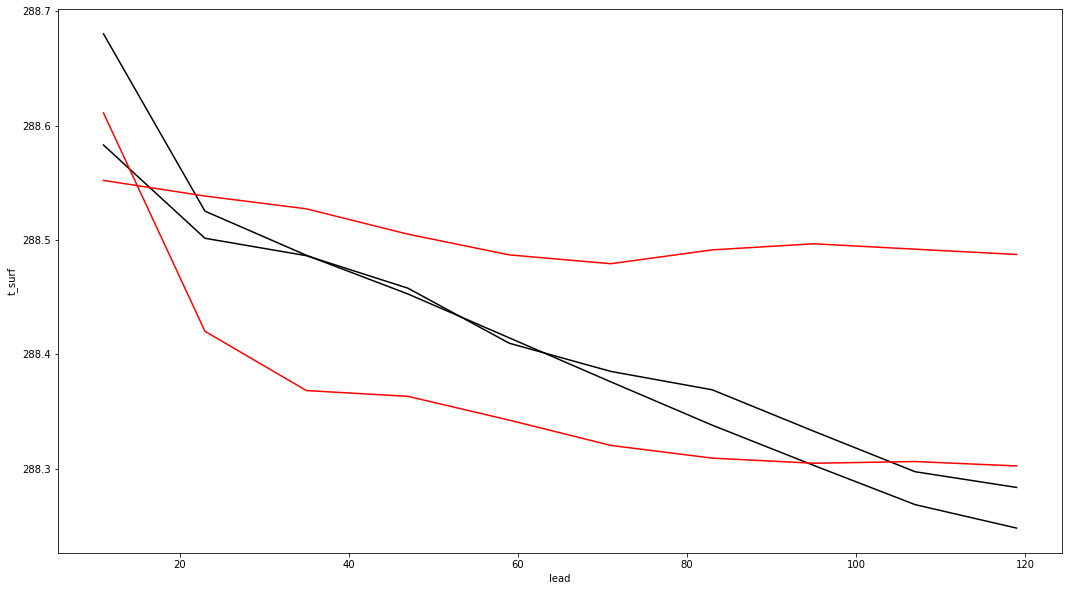

In [12]:
fig = plt.figure(figsize=(18, 10))

PERIOD_1 = slice("1995", "2004")
PERIOD_2 = slice("2005", "2014")

hcst_gbl.sel(init=PERIOD_1).groupby("init.month").mean("init").plot.line(
    x="lead", add_legend=False, color="k"
)

hcst_gbl.sel(init=PERIOD_2).groupby("init.month").mean("init").plot.line(
    x="lead", add_legend=False, color="r"
)

Text(0.5, 1.0, '')

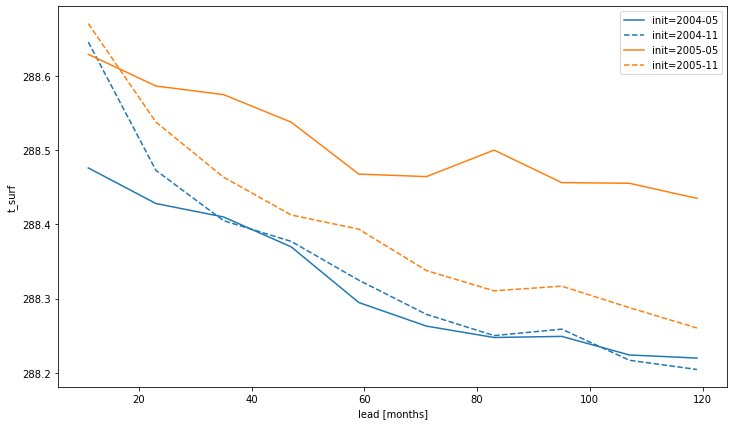

In [13]:
fig = plt.figure(figsize=(12, 7))
hcst_gbl.sel(init="2004-05").plot(color="C0", label="init=2004-05")
hcst_gbl.sel(init="2004-11").plot(color="C0", linestyle="--", label="init=2004-11")
hcst_gbl.sel(init="2005-05").plot(color="C1", label="init=2005-05")
hcst_gbl.sel(init="2005-11").plot(color="C1", linestyle="--", label="init=2005-11")
plt.legend()
plt.xlabel("lead [months]")
plt.title("")

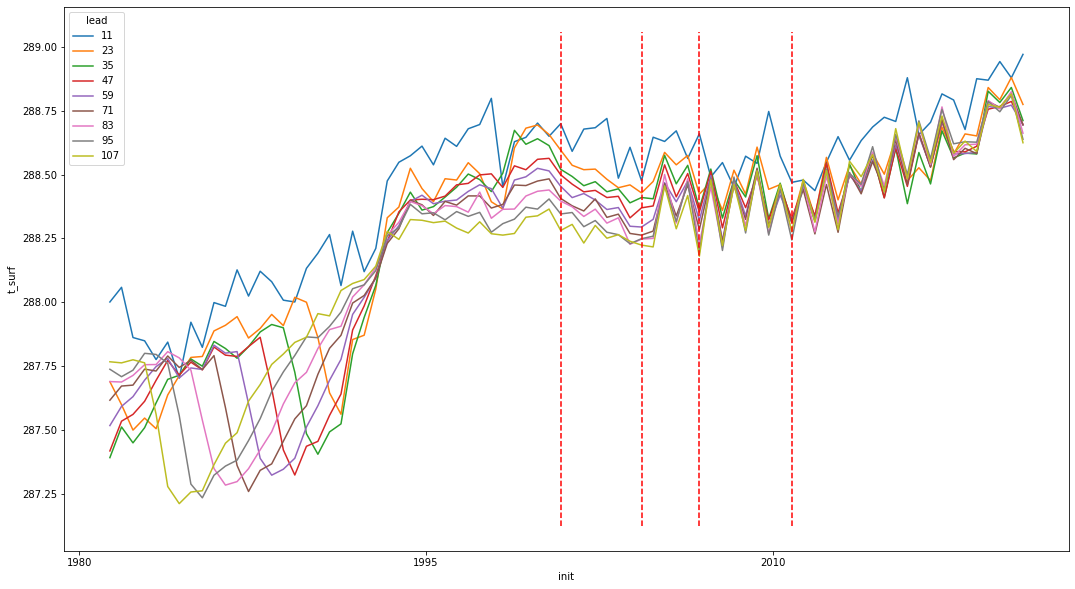

In [14]:
lead = range(11, 119, 12)

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(18, 10))
# hcst_gbl[1::2].sel(lead=lead).plot.line(x="init", add_legend=True)
# hcst_gbl[::2].sel(lead=lead).plot.line(x="init", linestyle="--", add_legend=True)
hcst_gbl.sel(lead=lead).plot.line(x="init", add_legend=True)

ylim = plt.gca().get_ylim()
# plt.plot(
#     [cftime.DatetimeJulian(2005, 1, 1), cftime.DatetimeJulian(2005, 1, 1)],
#     ylim,
#     color="k",
#     linestyle="--",
# )

dates = [
    cftime.DatetimeJulian(2000, 11, 1),
    cftime.DatetimeJulian(2004, 5, 1),
    cftime.DatetimeJulian(2006, 11, 1),
    cftime.DatetimeJulian(2010, 11, 1),
]

for date in dates:
    plt.plot(
        [date, date],
        ylim,
        color="r",
        linestyle="--",
    )


# for c, l in enumerate(lead):
#     plt.plot(
#         xr.CFTimeIndex(
#             [cftime.DatetimeJulian(1991, 6, 1), cftime.DatetimeJulian(1991, 6, 1)]
#         ).shift(-l, freq="MS"),
#         ylim,
#         color=f"C{c}",
#         linestyle="--",
#     )

# Plot May and Nov separately

### May

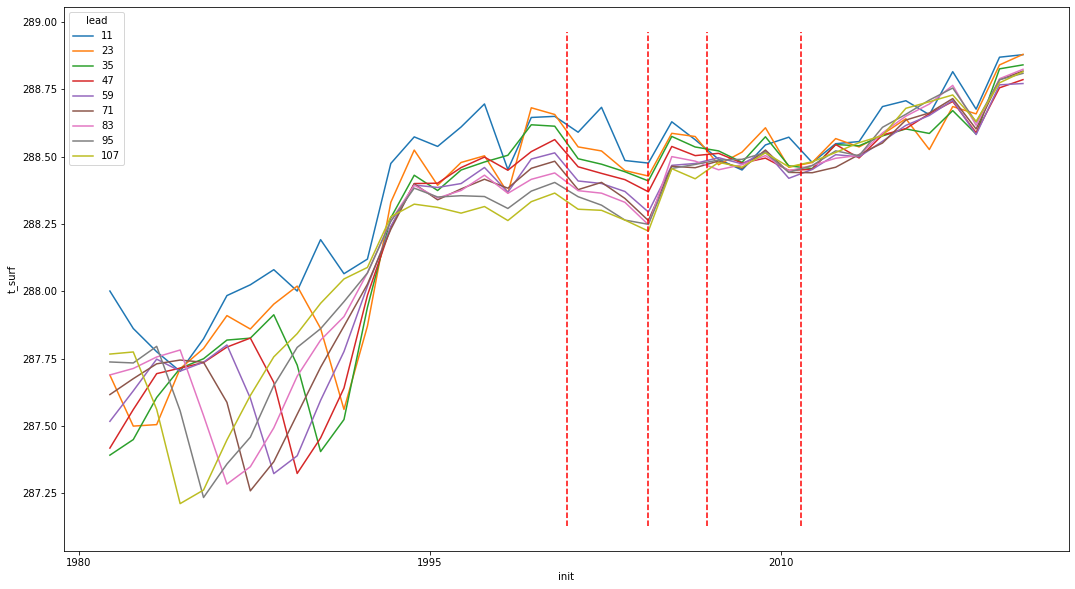

In [15]:
lead = range(11, 119, 12)

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(18, 10))
hcst_gbl[::2].sel(lead=lead).plot.line(x="init", add_legend=True)

ylim = plt.gca().get_ylim()
# plt.plot(
#     [cftime.DatetimeJulian(2005, 1, 1), cftime.DatetimeJulian(2005, 1, 1)],
#     ylim,
#     color="k",
#     linestyle="--",
# )

dates = [
    cftime.DatetimeJulian(2000, 11, 1),
    cftime.DatetimeJulian(2004, 5, 1),
    cftime.DatetimeJulian(2006, 11, 1),
    cftime.DatetimeJulian(2010, 11, 1),
]

for date in dates:
    plt.plot(
        [date, date],
        ylim,
        color="r",
        linestyle="--",
    )


# for c, l in enumerate(lead):
#     plt.plot(
#         xr.CFTimeIndex(
#             [cftime.DatetimeJulian(1991, 6, 1), cftime.DatetimeJulian(1991, 6, 1)]
#         ).shift(-l, freq="MS"),
#         ylim,
#         color=f"C{c}",
#         linestyle="--",
#     )

### Nov

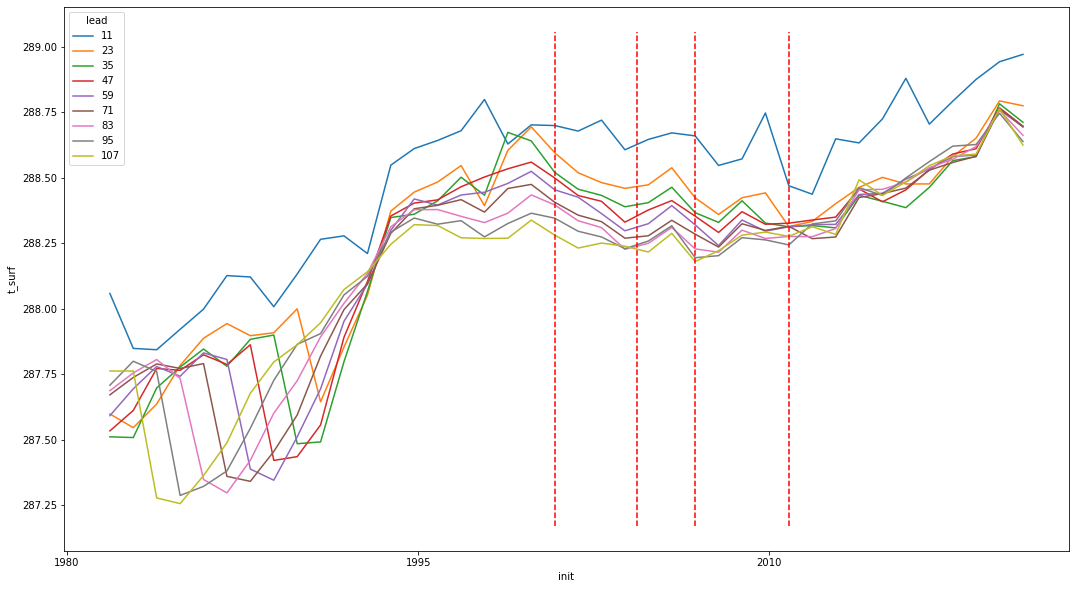

In [16]:
lead = range(11, 119, 12)

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(18, 10))
hcst_gbl[1::2].sel(lead=lead).plot.line(x="init", add_legend=True)

ylim = plt.gca().get_ylim()
# plt.plot(
#     [cftime.DatetimeJulian(2005, 1, 1), cftime.DatetimeJulian(2005, 1, 1)],
#     ylim,
#     color="k",
#     linestyle="--",
# )

dates = [
    cftime.DatetimeJulian(2000, 11, 1),
    cftime.DatetimeJulian(2004, 5, 1),
    cftime.DatetimeJulian(2006, 11, 1),
    cftime.DatetimeJulian(2010, 11, 1),
]

for date in dates:
    plt.plot(
        [date, date],
        ylim,
        color="r",
        linestyle="--",
    )


# for c, l in enumerate(lead):
#     plt.plot(
#         xr.CFTimeIndex(
#             [cftime.DatetimeJulian(1991, 6, 1), cftime.DatetimeJulian(1991, 6, 1)]
#         ).shift(-l, freq="MS"),
#         ylim,
#         color=f"C{c}",
#         linestyle="--",
#     )

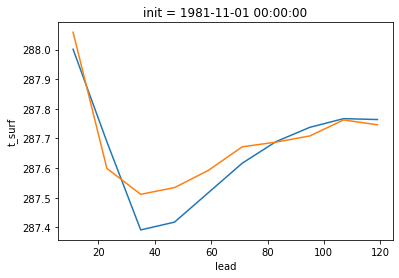

In [17]:
hcst_gbl[0].plot.line(x="lead", color="C0", add_legend=False)
hcst_gbl[1].plot.line(x="lead", color="C1", add_legend=False)

# What about our Fire Susceptibility region

In [18]:
mask = xr.open_dataset(
    "../resources/g.data.xv83.users.ds0092.active_projects.Squire_2021_fire_susceptibility.data.region_mask.ONDJF.10.nc"
)["region_mask"]

In [19]:
hcst_fs = (
    cafe_hcst.where(mask).weighted(cafe_hcst["area"]).mean(["lat", "lon", "member"])
)

/g/data/xv83/users/ds0092/software/miniconda3/envs/xmovie/lib/python3.9/site-packages/xarray/core/indexing.py:1233: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


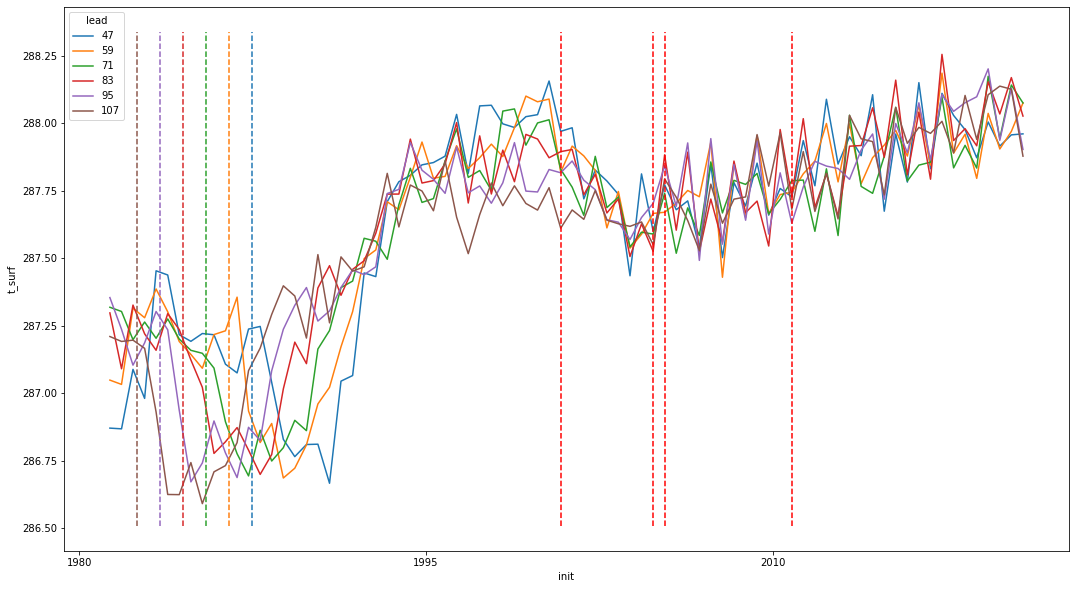

In [20]:
lead = range(47, 119, 12)

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(18, 10))
hcst_fs.sel(lead=lead).plot.line(x="init", add_legend=True)
ylim = plt.gca().get_ylim()
# plt.plot(
#     [cftime.DatetimeJulian(2005, 1, 1), cftime.DatetimeJulian(2005, 1, 1)],
#     ylim,
#     color="k",
#     linestyle="--",
# )

dates = [
    cftime.DatetimeJulian(2000, 11, 1),
    cftime.DatetimeJulian(2004, 11, 1),
    cftime.DatetimeJulian(2005, 5, 1),
    cftime.DatetimeJulian(2010, 11, 1),
]

for date in dates:
    plt.plot(
        [date, date],
        ylim,
        color="r",
        linestyle="--",
    )


for c, l in enumerate(lead):
    plt.plot(
        xr.CFTimeIndex(
            [cftime.DatetimeJulian(1991, 6, 1), cftime.DatetimeJulian(1991, 6, 1)]
        ).shift(-l, freq="MS"),
        ylim,
        color=f"C{c}",
        linestyle="--",
    )

# How does the namelist change across this period?

In [21]:
!diff ../resources/c5-d60-pX-f6-20041101-base.MOM.input.nml ../resources/c5-d60-pX-f6-20050501-base.MOM.input.nml

962,963c962,963
<     basic_ozone_type = 'time_varying'
<     !ozone_dataset_entry=2014, 1, 1, 0, 0, 0,
---
>     basic_ozone_type = 'fixed_year'
>     ozone_dataset_entry=2014, 1, 1, 0, 0, 0,
965c965
<     filename = CM3_CMIP6_1950-2014_O3.nc
---
>     filename = cm3_2014_o3.padded.nc


# This is the point at which we change from time varying ozone forcing (with lead using `CM3_CMIP6_1950-2014_O3.nc`) to fixed year (2014 using `cm3_2014_o3.padded.nc`) forcing

In [13]:
ozone_pre = xr.open_dataset(
    "../resources/c5-d60-pX-f6-20101101-base.MOM.INPUT.CM3_CMIP6_1950-2014_O3.nc"
)["ozone"]

ozone_post = xr.open_dataset(
    "../resources/c5-d60-pX-f6-20101101-base.MOM.INPUT.cm3_2014_o3.padded.nc"
)["ozone"]

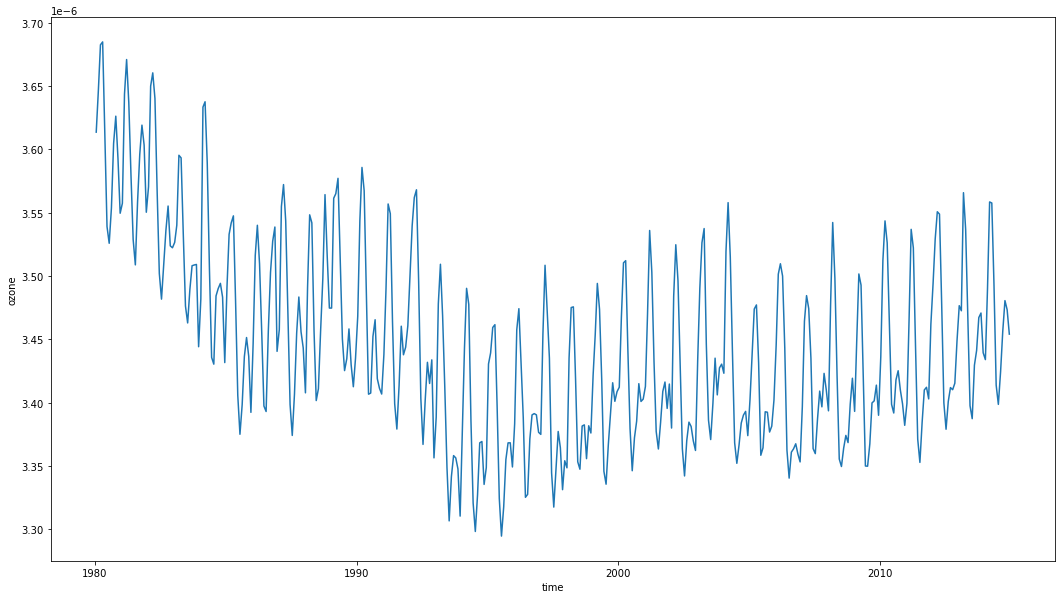

In [14]:
fig = plt.figure(figsize=(18, 10))
ozone_pre.sel(time=slice("1980", None)).mean(["lat", "lon", "pfull"]).plot()

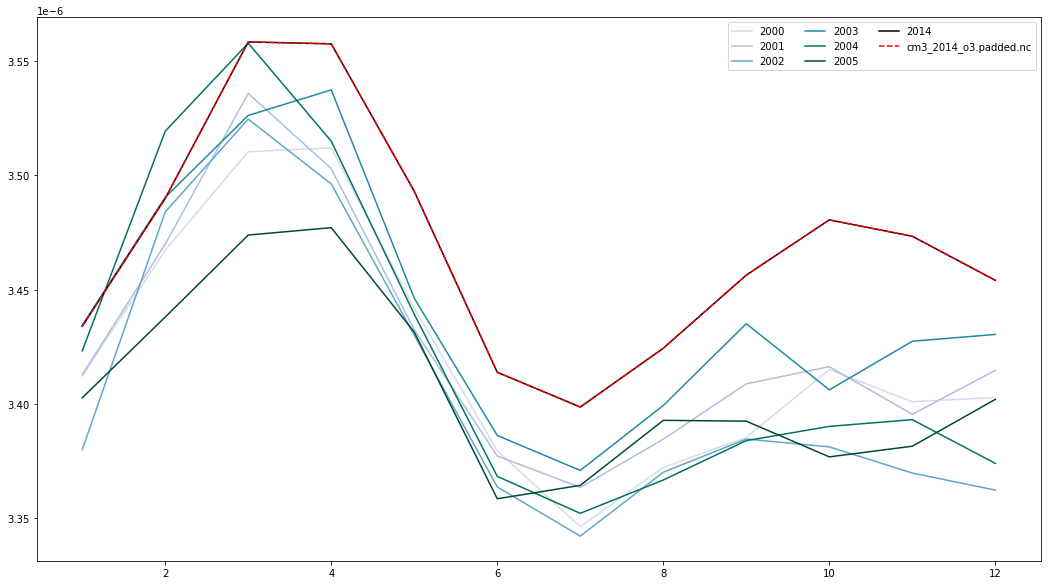

In [16]:
fig = plt.figure(figsize=(18, 10))
from matplotlib.pyplot import cm

level = slice(0, None)  # [10]

gbl_pre = ozone_pre.isel(pfull=level).mean(["lat", "lon", "pfull"])
years = range(2000, 2006)
colors = cm.PuBuGn(np.linspace(0.2, 1, len(years)))
for year, c in zip(years, colors):
    gbl = gbl_pre.sel(time=str(year))
    plt.plot(range(1, 13), gbl, label=str(year), color=c)
plt.plot(range(1, 13), gbl_pre.sel(time="2014"), label="2014", color="k")

gbl_post = ozone_post.isel(pfull=level).mean(["lat", "lon", "pfull"])
plt.plot(
    range(1, 13),
    gbl_post.sel(time="2014"),
    label="cm3_2014_o3.padded.nc",
    color="r",
    linestyle="--",
)

plt.legend(ncol=3)

# What do the historical data do?

In [17]:
data_dir = "/g/data/xv83/users/ds0092/data/CAFE/historical/WIP"
realm = "atmos_isobaric_month.zarr.zip"

In [18]:
cafe_hist = truncate_latitudes(
    xr.open_zarr(f"{data_dir}/c5-d60-pX-hist-19601101/ZARR/{realm}")
)["t_surf"]

cafe_hist = cafe_hist.rename({"ensemble": "member"})  # Req by climpred

cafe_hist = round_to_start_of_month(cafe_hist, dim="time")

# Process annual means to match hcst dataset
cafe_hist = xr.concat(
    [
        coarsen_monthly_to_annual(cafe_hist, cafe_hcst.init[0]),
        coarsen_monthly_to_annual(cafe_hist, cafe_hcst.init[1]),
    ],
    dim="time",
).sortby("time")

/g/data/xv83/users/ds0092/software/miniconda3/envs/pangeo/lib/python3.9/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing with an out-of-order index is generating 59 times more chunks
  return self.array[key]
/g/data/xv83/users/ds0092/software/miniconda3/envs/pangeo/lib/python3.9/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing with an out-of-order index is generating 59 times more chunks
  return self.array[key]
/g/data/xv83/users/ds0092/software/miniconda3/envs/pangeo/lib/python3.9/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing with an out-of-order index is generating 59 times more chunks
  return self.array[key]


In [19]:
hist_gbl = cafe_hist.weighted(cafe_hist["area"]).mean(["lat", "lon", "member"])

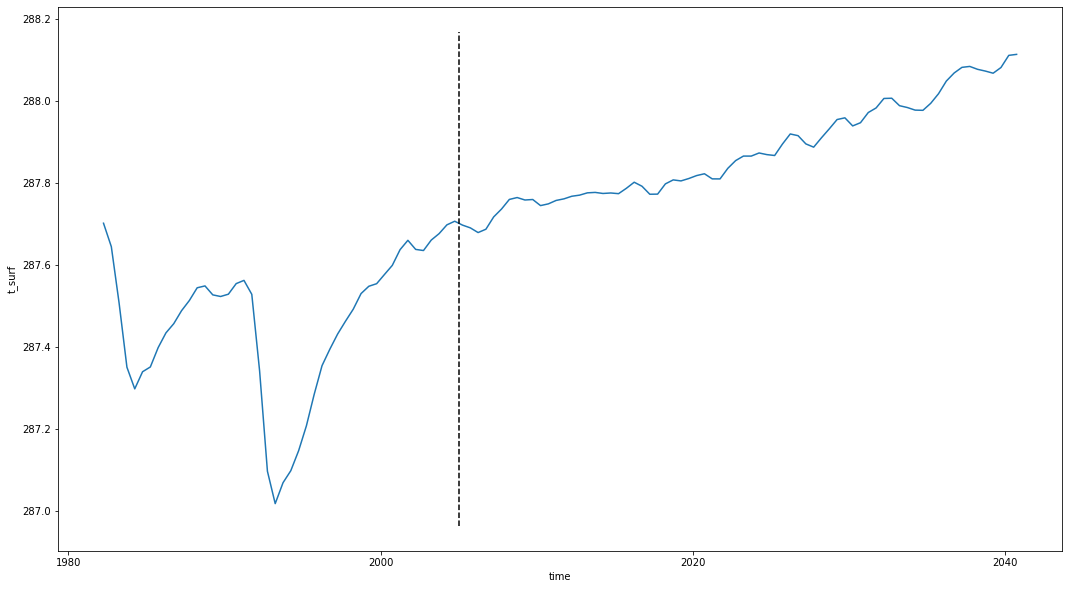

In [20]:
fig = plt.figure(figsize=(18, 10))

hist_gbl.plot()

ylim = plt.gca().get_ylim()
plt.plot(
    [cftime.DatetimeJulian(2005, 1, 1), cftime.DatetimeJulian(2005, 1, 1)],
    ylim,
    color="k",
    linestyle="--",
)

# Compare forecasts with and without timevarying ozone forcing

In [6]:
realm = "atmos_isobaric_month.zarr.zip"

path = "/g/data/xv83/users/ds0092/data/CAFE/forecasts/f6/WIP/c5-d60-pX-f6-20040501-fixed_ozone/ZARR/"
files = sorted(glob.glob(f"{path}mem*/{realm}"))
fixed = open_mfzarr(files)[["t_surf", "qo3_col"]].compute()

path = "/g/data/xv83/dcfp/CAFE-f6"
tv = xr.open_zarr(f"{path}/c5-d60-pX-f6-20040501/{realm}")[
    ["t_surf", "qo3_col"]
].compute()

In [7]:
gbl_fixed = (
    coarsen_monthly_to_annual(fixed["t_surf"])
    .weighted(fixed["area"])
    .mean(["lat", "lon", "ensemble"])
)
gbl_tv = (
    coarsen_monthly_to_annual(tv["t_surf"])
    .weighted(tv["area"])
    .mean(["lat", "lon", "ensemble"])
)

Text(0.5, 1.0, 'Global mean forecast initialised 2004-05-01')

<Figure size 1080x504 with 0 Axes>

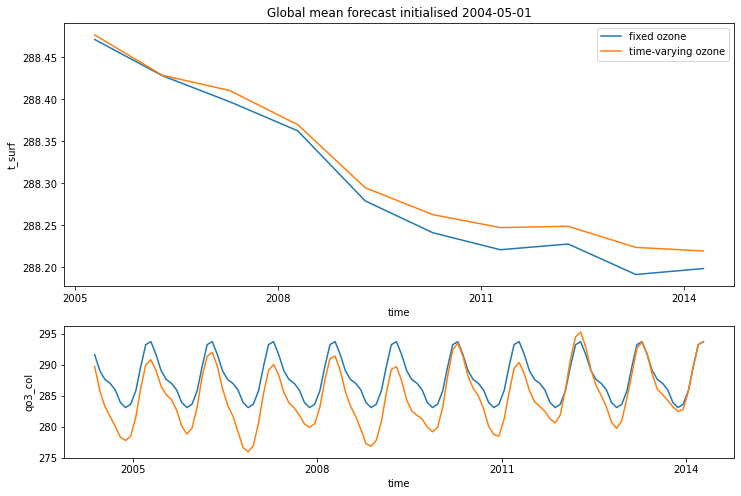

In [8]:
fig = plt.figure(figsize=(15, 7))

fig, (ax0, ax1) = plt.subplots(
    2,
    1,
    gridspec_kw={
        "height_ratios": [
            2,
            1,
        ]
    },
    figsize=(12, 8),
)

gbl_fixed.plot(ax=ax0, label="fixed ozone")
gbl_tv.plot(ax=ax0, label="time-varying ozone")
ax0.legend()

fixed["qo3_col"].weighted(fixed["area"]).mean(["lat", "lon", "ensemble"]).plot(ax=ax1)
tv["qo3_col"].weighted(tv["area"]).mean(["lat", "lon", "ensemble"]).plot(ax=ax1)

ax0.set_title("Global mean forecast initialised 2004-05-01")

# Compare same forecasts run by me and Vassili

In [9]:
realm = "atmos_isobaric_month.zarr.zip"

path = "/g/data/xv83/users/ds0092/data/CAFE/forecasts/f6/WIP/c5-d60-pX-f6-20061101-rerun/ZARR/"
files = sorted(glob.glob(f"{path}mem*/{realm}"))
dougie = open_mfzarr(files)[["t_surf", "qo3_col"]].compute()
completed_members = dougie.ensemble

path = "/g/data/xv83/dcfp/CAFE-f6"
vassili = xr.open_zarr(f"{path}/c5-d60-pX-f6-20061101/{realm}")[
    ["t_surf", "qo3_col"]
].compute()
vassili = vassili.sel(ensemble=completed_members)

In [27]:
gbl_dougie = (
    coarsen_monthly_to_annual(dougie["t_surf"])
    .weighted(dougie["area"])
    .mean(["lat", "lon", "ensemble"])
)
gbl_vassili = (
    coarsen_monthly_to_annual(vassili["t_surf"])
    .weighted(vassili["area"])
    .mean(["lat", "lon", "ensemble"])
)

Text(0.5, 1.0, 'Global mean forecast initialised 2006-11-01')

<Figure size 1080x504 with 0 Axes>

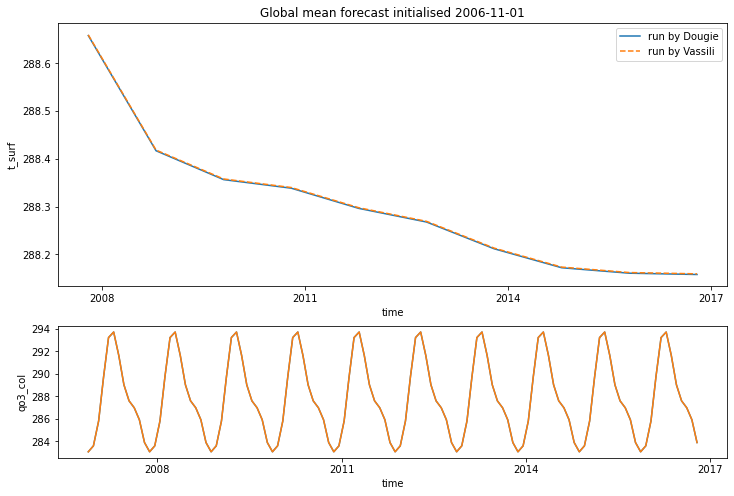

In [28]:
fig = plt.figure(figsize=(15, 7))

fig, (ax0, ax1) = plt.subplots(
    2,
    1,
    gridspec_kw={
        "height_ratios": [
            2,
            1,
        ]
    },
    figsize=(12, 8),
)

gbl_dougie.plot(ax=ax0, label="run by Dougie")
gbl_vassili.plot(ax=ax0, label="run by Vassili", linestyle="--")
ax0.legend()

dougie["qo3_col"].weighted(dougie["area"]).mean(["lat", "lon", "ensemble"]).plot(ax=ax1)
vassili["qo3_col"].weighted(vassili["area"]).mean(["lat", "lon", "ensemble"]).plot(
    ax=ax1
)

ax0.set_title("Global mean forecast initialised 2006-11-01")

# How do fields at subsequent lead times compare to lead 0? I.e. where is the drift?

In [73]:
lead = 5
period = slice("1987", "2021")

In [74]:
ref = (
    cafe_hcst.sel(lat=slice(-40, 40))
    .mean("member")
    .isel(lead=0)
    .swap_dims({"init": "time"})
    .sel(time=period)
)
cmp = (
    cafe_hcst.sel(lat=slice(-40, 40))
    .mean("member")
    .isel(lead=lead)
    .swap_dims({"init": "time"})
    .sel(time=period)
)

diff = (cmp - ref).compute()
diff = diff.assign_coords({"init_date": cmp.init})

In [77]:
start_month = "May"
to_drop = ["average_DT", "average_T1", "average_T2"]

if start_month == "May":
    field = diff.where(diff.time.dt.month == 4, drop=True).rename("field").drop(to_drop)
    ts = (
        hcst_gbl.where(hcst_gbl.init.dt.month == 5, drop=True)
        .rename("ts")
        .drop(to_drop)
    )
elif start_month == "Nov":
    field = (
        diff.where(diff.time.dt.month == 10, drop=True).rename("field").drop(to_drop)
    )
    ts = (
        hcst_gbl.where(hcst_gbl.init.dt.month == 11, drop=True)
        .rename("ts")
        .drop(to_drop)
        .rename({"time": "times"})
    )

to_plot = xr.merge([field, ts]).compute()

In [78]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


def make_plot(ds, fig, tt, *args, **kwargs):
    gs = gridspec.GridSpec(2, 1, height_ratios=[1.6, 1])
    ax1 = fig.add_subplot(gs[0], projection=ccrs.PlateCarree(180))
    ax2 = fig.add_subplot(gs[1])

    # Map axis
    data = ds["field"].isel({"time": tt}).rename("t_surf")
    init = data.init_date
    time = data.time
    im = data.plot(
        ax=ax1,
        vmin=kwargs["vmin"],
        vmax=kwargs["vmax"],
        cmap="RdBu_r",
        transform=ccrs.PlateCarree(),
        add_colorbar=True,
    )
    im.axes.coastlines(color="k")
    ax1.set_title(
        f"Difference between lead {lead} and 0 {start_month} annual mean forecasts"
        + "\n"
        + f"Comparison time: {time.item()}"
        + "\n"
        + f"Initial date of lead {lead} forecast: {init.item()}",
        fontsize=12,
    )

    #     divider = make_axes_locatable(ax1)
    #     cax = divider.append_axes("right", size="2%", pad=0.1)
    #     fig.colorbar(im, cax=cax, orientation="vertical")

    # Time series
    data = ds["ts"].rename("Global t_surf")
    data.plot.line(
        ax=ax2, x="init", add_legend=False, color="grey", label="__nolabel__"
    )
    data.isel(lead=0).plot.line(
        ax=ax2, x="init", add_legend=False, color="k", label="lead 0"
    )
    data.isel(lead=lead).plot.line(
        ax=ax2, x="init", add_legend=False, color="C0", label=f"lead {lead}"
    )
    ylims = ax2.get_ylim()
    init_index = np.where(data.init.values == init.item())[0]
    assert data.isel(init=init_index).init.item() == init.item()
    ax2.plot(
        [init.item(), init.item()],
        ylims,
        color="k",
        linestyle="--",
    )
    ax2.plot(
        [
            data.isel(init=init_index + lead).init.item(),
            data.isel(init=init_index).init.item(),
        ],
        [
            data.isel(init=init_index + lead).isel(lead=0),
            data.isel(init=init_index).isel(lead=lead),
        ],
        color="C1",
        marker="o",
    )
    ax2.set_title("")
    ax2.legend(fontsize=10, loc="lower right")

    fig.subplots_adjust(hspace=0.1)

    return None, None


mov_custom = Movie(
    to_plot,
    make_plot,
    vmin=-3,
    vmax=3,
    pixelwidth=1420,
    pixelheight=1080,
    dpi=160,
    input_check=False,
)
mov_custom.save(
    f"{start_month}_starts.Lead_{lead}.Tropics.mp4", overwrite_existing=True
)

Movie created at May_starts.Lead_5.Tropics.mp4


# Breaking the above videos down by hemisphere, it actually becomes clear that it's the drift behaviour in the SH that changes in 2005

# Possibly due to our model's large biases in the southern ocean

# Let's switch to sst

In [31]:
SO_region = slice(-90, -30)

In [32]:
data_dir = "/g/data/xv83/dcfp/CAFE-f6"
realm = "ocean_month.zarr.zip"

files = sorted(glob.glob(f"{data_dir}/c5-d60-pX-f6-*/{realm}"))

In [33]:
cafe_hcst = open_mfzarr(
    files, preprocess=preprocess_CAFEf6_monthly_to_annual, parallel=False
)["sst"]

cafe_hcst = cafe_hcst.persist()

/g/data/xv83/users/ds0092/software/miniconda3/envs/xesmf/lib/python3.9/site-packages/xarray/core/dataset.py:6698: PerformanceWarning: Increasing number of chunks by factor of 50
  return unify_chunks(self)[0]


# Plot strange behaviour in forecasts

In [34]:
hcst_SO = (
    cafe_hcst.sel(yt_ocean=SO_region)
    .weighted(cafe_hcst["area_t"])
    .mean(["xt_ocean", "yt_ocean", "member"])
)

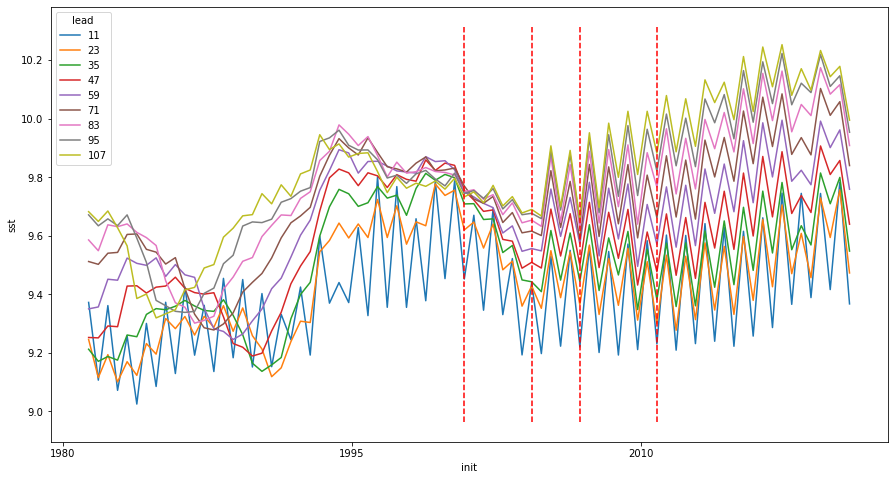

In [35]:
lead = range(11, 119, 12)

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 8))
# hcst_SO[::2].sel(lead=lead).plot.line(x="init", add_legend=True)
# hcst_SO[::2].sel(lead=lead).plot.line(x="init", linestyle="--", add_legend=True)
hcst_SO.sel(lead=lead).plot.line(x="init", add_legend=True)

ylim = plt.gca().get_ylim()
# plt.plot(
#     [cftime.DatetimeJulian(2005, 1, 1), cftime.DatetimeJulian(2005, 1, 1)],
#     ylim,
#     color="k",
#     linestyle="--",
# )

dates = [
    cftime.DatetimeJulian(2000, 11, 1),
    cftime.DatetimeJulian(2004, 5, 1),
    cftime.DatetimeJulian(2006, 11, 1),
    cftime.DatetimeJulian(2010, 11, 1),
]

for date in dates:
    plt.plot(
        [date, date],
        ylim,
        color="r",
        linestyle="--",
    )


# for c, l in enumerate(lead):
#     plt.plot(
#         xr.CFTimeIndex(
#             [cftime.DatetimeJulian(1991, 6, 1), cftime.DatetimeJulian(1991, 6, 1)]
#         ).shift(-l, freq="MS"),
#         ylim,
#         color=f"C{c}",
#         linestyle="--",
#     )

# How is our model biased in the Southern Ocean? Let's use the control run to investigate

### HadISST data

In [134]:
data_dir = "/g/data/xv83/reanalyses/HadISST/"
realm = "ocean_month.zarr"

had = xr.open_zarr(f"{data_dir}/{realm}", use_cftime=True)["sst"].sortby("latitude")
had = round_to_start_of_month(had, dim="time")
had = had.where(had >= -999).rename(
    {"longitude": "lon", "latitude": "lat"}
)  # Remove sea ice

had = had.assign_coords({"area": estimate_cell_areas(had)})

### CAFE control data

In [59]:
data_dir = (
    "/g/data/xv83/users/ds0092/data/CAFE/historical/WIP/c5-d60-pX-ctrl-19601101/ZARR/"
)
realm = "ocean_month.zarr.zip"

cafe_ctrl = xr.open_zarr(f"{data_dir}/{realm}")["sst"]

#### Interpolate onto HadISST grid

In [61]:
ds_in = cafe_ctrl.rename(
    {"xt_ocean": "x", "yt_ocean": "y", "geolon_t": "lon", "geolat_t": "lat"}
)
ds_out = had["area"]

regridder = xesmf.Regridder(ds_in, ds_out, "bilinear")
cafe_ctrl_re = regridder(ds_in).mean("ensemble").compute()

/g/data/xv83/users/ds0092/software/miniconda3/envs/xesmf/lib/python3.9/site-packages/dask/array/core.py:405: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/g/data/xv83/users/ds0092/software/miniconda3/envs/xesmf/lib/python3.9/site-packages/xarray/core/dataarray.py:784: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


### Compare the climatologies

In [62]:
clim_period = slice("1991", "2020")

In [63]:
ctrl_clim = cafe_ctrl_re.sel(time=clim_period).groupby("time.month").mean("time")
had_clim = had.sel(time=clim_period).groupby("time.month").mean("time")

diff = ctrl_clim - had_clim
diff = diff.assign_coords(
    {
        "month": [
            "Jan",
            "Feb",
            "Mar",
            "Apr",
            "May",
            "Jun",
            "Jul",
            "Aug",
            "Sep",
            "Oct",
            "Nov",
            "Dec",
        ]
    }
)

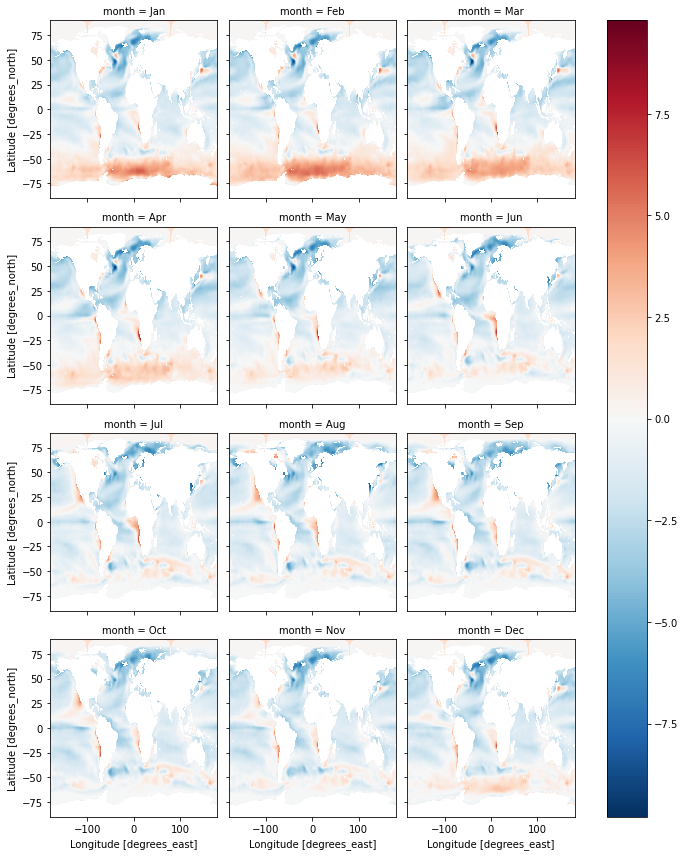

In [64]:
diff.plot(x="lon", y="lat", col="month", col_wrap=3)
plt.savefig(f"SST_bias.png", format="png", bbox_inches="tight")

# Focus on monthly forecast data

In [88]:
def preprocess_CAFEf6(ds):
    """Preprocessing steps for CAFE-f6 data"""

    ds = round_to_start_of_month(ds, dim="time")
    ds = convert_time_to_lead(ds)

    # Truncate lats so that forecasts run on different systems can be stacked
    ds = truncate_latitudes(ds)

    # Required by climpred
    ds = ds.rename({"ensemble": "member"})
    ds["lead"].attrs["units"] = "months"
    return ds

In [89]:
data_dir = "/g/data/xv83/dcfp/CAFE-f6"
realm = "ocean_month.zarr.zip"

files = sorted(glob.glob(f"{data_dir}/c5-d60-pX-f6-*/{realm}"))

In [90]:
cafe_hcst = open_mfzarr(files, preprocess=preprocess_CAFEf6, parallel=False)["sst"]

# cafe_hcst = cafe_hcst.persist()

/g/data/xv83/users/ds0092/software/miniconda3/envs/xesmf/lib/python3.9/site-packages/xarray/core/dataset.py:6698: PerformanceWarning: Increasing number of chunks by factor of 50
  return unify_chunks(self)[0]


In [93]:
# Keep only SO average and first 12 months
hcst_SO = (
    cafe_hcst.sel(yt_ocean=SO_region)
    .weighted(cafe_hcst["area_t"])
    .mean(["xt_ocean", "yt_ocean", "member"])
).compute()

In [136]:
had_SO = (
    had.sel(lat=SO_region).weighted(had["area"].fillna(0)).mean(["lon", "lat"])
).compute()

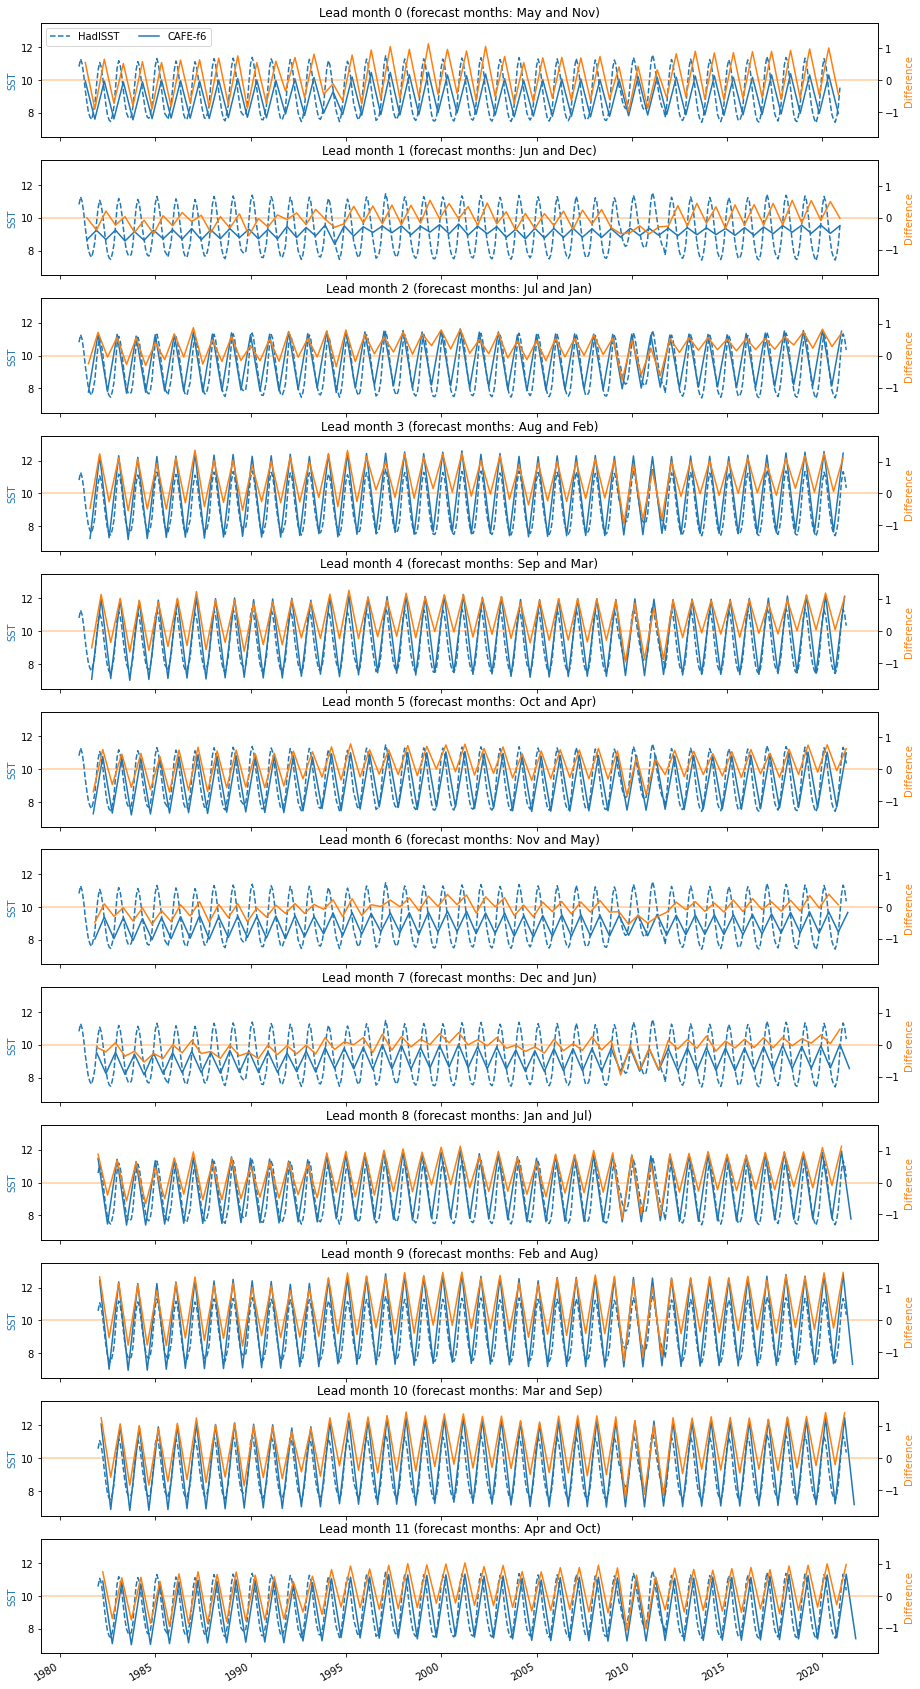

In [188]:
leads = range(12)

fig = plt.figure(figsize=(15, 30))

axs = fig.subplots(len(leads), 1, sharex=True)
months = [
    "Jan",
    "Feb",
    "Mar",
    "Apr",
    "May",
    "Jun",
    "Jul",
    "Aug",
    "Sep",
    "Oct",
    "Nov",
    "Dec",
]

for i, l in enumerate(leads):
    ax = axs[i]
    hcst_ts = hcst_SO.sel(lead=l).swap_dims({"init": "time"})
    hcst_ts = hcst_ts.assign_coords(
        {"time": xr.coding.times.cftime_to_nptime(hcst_ts.time)}
    )
    min_year = str(min(hcst_ts.time.dt.year).item())
    max_year = str(max(hcst_ts.time.dt.year).item())

    had_ts = had_SO.sel(time=slice(min_year, max_year))
    had_ts = had_ts.assign_coords(
        {"time": xr.coding.times.cftime_to_nptime(had_ts.time)}
    )

    had_ts.plot(ax=ax, color="C0", linestyle="--", label="HadISST")
    hcst_ts.plot(ax=ax, color="C0", linestyle="-", label="CAFE-f6")
    ax.set_ylabel("SST", color="C0")
    ax.set_xlabel("")
    ax.set_ylim((6.5, 13.5))
    ax.set_title(
        f"Lead month {l} (forecast months: {months[(i+4) % 12]} and {months[(i+10) % 12]})"
    )

    if i == 0:
        ax.legend(ncol=2, loc="upper left")

    axt = ax.twinx()
    xlim = axt.get_xlim()
    axt.plot(xlim, [0, 0], color="C1", alpha=0.4)
    (hcst_ts - had_ts).plot(ax=axt, color="C1")
    axt.set_ylabel("Difference", color="C1")
    axt.set_ylim((-1.8, 1.8))
    axt.set_title("")
    axt.set_xlim(xlim)

plt.savefig(f"SST_bias_evolution.png", format="png", bbox_inches="tight")

# Plot the average evolution of the biases for the May and Nov forecasts

In [276]:
def reindex_forecast(
    ds,
    init_date_dim="init_date",
    lead_time_dim="lead_time",
    time_dim="time",
    dropna=False,
):
    """Restack by time (lead_time) a forecast dataset stacked by lead_time (time)
    Only works on DataArrays at the moment
    """
    if lead_time_dim in ds.dims:
        index_dim = lead_time_dim
        reindex_dim = time_dim
    elif time_dim in ds.dims:
        index_dim = time_dim
        reindex_dim = lead_time_dim
    else:
        raise ValueError("Neither a time nor lead_time dimension can be found")
    swap = {index_dim: reindex_dim}

    reindex_coord = np.sort(np.unique(ds[reindex_dim]))
    reindex_coord = xr.DataArray(
        reindex_coord, dims=[reindex_dim], coords={reindex_dim: reindex_coord}
    )
    reindex_coord = reindex_coord[
        reindex_coord.notnull()
    ]  # Using "where" here cast datetime dtypes badly

    def _pad(ds, reindex):
        """Pad with nans to fill out reindex dimension"""
        reindex_pad = reindex[~np.in1d(reindex, ds[reindex_dim])]
        if len(reindex_pad) > 0:
            template = ds.isel(
                {reindex_dim: len(reindex_pad) * [0]}, drop=True
            ).assign_coords({reindex_dim: reindex_pad})
            if ds.chunks is not None:
                ax = ds.get_axis_num(reindex_dim)
                template = template.chunk({reindex_dim: ds.chunks[ax][0]})
            padding = xr.full_like(template, np.nan, ds.dtype)
            # Force index dim to be nans where padded
            padding = padding.assign_coords(
                {
                    index_dim: xr.full_like(
                        template[index_dim].compute(), np.nan, ds.dtype
                    )
                }
            )
            return xr.concat([ds, padding], dim=reindex_dim)
        else:
            return ds

    to_concat = []
    for init_date in ds[init_date_dim]:
        fcst = ds.sel({init_date_dim: init_date})
        fcst = fcst.where(fcst[reindex_dim].notnull(), drop=True)
        # Broadcasting times when stacking by init_date generates large chunks so stack manually
        fcst_padded = _pad(fcst.swap_dims(swap), reindex_coord)
        to_concat.append(fcst_padded)

    concat = xr.concat(to_concat, dim=init_date_dim)
    if dropna:
        return concat.where(concat.notnull(), drop=True)
    else:
        return concat

In [201]:
hcst_SO_re = reindex_forecast(
    hcst_SO,
    init_date_dim="init",
    lead_time_dim="lead",
)

In [285]:
period_1 = slice("1991", "2004")  # 14 years
period_2 = slice("2005", "2020")  # 16 years

hcst_SO_np = hcst_SO_re.assign_coords(
    {"time": xr.coding.times.cftime_to_nptime(hcst_SO_re.time)}
)
had_SO_np = had_SO.assign_coords(
    {"time": xr.coding.times.cftime_to_nptime(had_SO.time)}
)

hcst_bias_re = hcst_SO_np.sel(time=period_1) - had_SO_np.sel(time=period_1)
hcst_bias_re = hcst_bias_re.assign_coords({"time": hcst_SO_re.sel(time=period_1).time})
hcst_bias_p1 = reindex_forecast(
    hcst_bias_re.where(hcst_bias_re.notnull(), drop=True),
    init_date_dim="init",
    lead_time_dim="lead",
)

hcst_bias_re = hcst_SO_np.sel(time=period_2) - had_SO_np.sel(time=period_2)
hcst_bias_re = hcst_bias_re.assign_coords({"time": hcst_SO_re.sel(time=period_2).time})
hcst_bias_p2 = reindex_forecast(
    hcst_bias_re.where(hcst_bias_re.notnull(), drop=True),
    init_date_dim="init",
    lead_time_dim="lead",
)

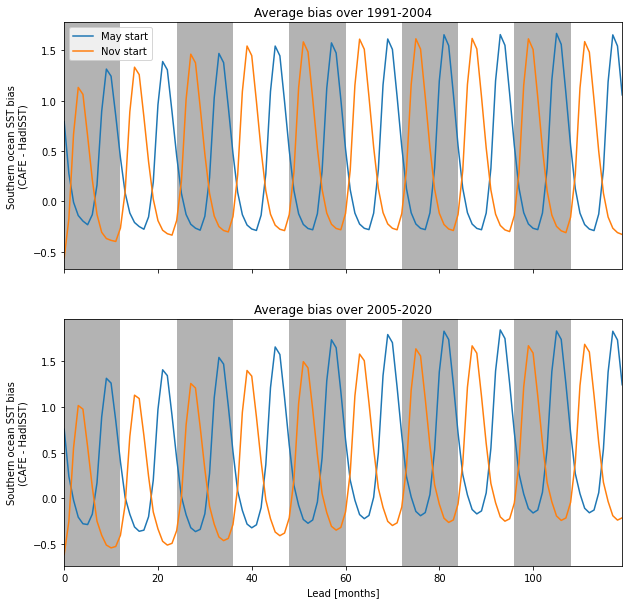

In [315]:
import matplotlib.patches as patches

fig = plt.figure(figsize=(10, 10))

axs = fig.subplots(2, 1, sharex=True)

hcst_bias_p1.where(hcst_bias_p1.init.dt.month == 5).mean("init").plot(
    ax=axs[0], label="May start"
)
hcst_bias_p1.where(hcst_bias_p1.init.dt.month == 11).mean("init").plot(
    ax=axs[0], label="Nov start"
)
axs[0].legend()
ylims = axs[0].get_ylim()
for i in range(0, 120, 24):
    rect = patches.Rectangle(
        (i, ylims[0]),
        12,
        ylims[1] - ylims[0],
        edgecolor="none",
        facecolor=[0.7, 0.7, 0.7],
    )
    axs[0].add_patch(rect)
axs[0].set_xlim(0, 119)
axs[0].set_title("Average bias over 1991-2004")
axs[0].set_xlabel("")
axs[0].set_ylabel("Southern ocean SST bias\n(CAFE - HadISST)")

hcst_bias_p2.where(hcst_bias_p2.init.dt.month == 5).mean("init").plot(ax=axs[1])
hcst_bias_p2.where(hcst_bias_p2.init.dt.month == 11).mean("init").plot(ax=axs[1])
ylims = axs[1].get_ylim()
for i in range(0, 120, 24):
    rect = patches.Rectangle(
        (i, ylims[0]),
        12,
        ylims[1] - ylims[0],
        edgecolor="none",
        facecolor=[0.7, 0.7, 0.7],
    )
    axs[1].add_patch(rect)
axs[1].set_xlim(0, 119)
axs[1].set_title("Average bias over 2005-2020")
axs[1].set_ylabel("Southern ocean SST bias\n(CAFE - HadISST)")
axs[1].set_xlabel("Lead [months]")

fig.patch.set_facecolor("w")
plt.savefig(f"SST_bias_with_lead.png", format="png", bbox_inches="tight")